# PSCCCCCCCC

In [1]:
import pandas as pd
import datetime
import numpy as np
import random
import time

# Chemin des fichiers
chemin_fichiers = 'Data/'

# Années disponibles 
annees_election = [1958,1962,1967,1968,1973,1978,1981,1988,1993,1997,2002,2007,2012,2017,2022]



In [2]:
# Fonction charger_tour
#     Chargement d'un tour d'élection
#     - Lecture du CSV
#     - Formation des données cumulées par circonscription
#     - Formation des données détailées par candidat
def charger_tour(annee, tour) :

    # Chargement des fichiers et normalisation
    # ----------------------------------------

    # lecture du fichier csv
    df_tour = pd.read_csv(
        chemin_fichiers + 'cdsp_legi' + str(annee) + 't'+ str(tour) + '_circ.csv', 
        sep= ',' if annee < 2017 else ';',
        dtype= {'Code département':str, 'Code du département':str})

    # Ajout de l'année
    df_tour.insert(0, "Année", annee)

    # Avant 1981 : recopie de la seconde ligne d'en-tête dans la première et suppression 
    if annee < 1981 :
        for i in range (1,len(df_tour.columns)) : 
            lib = str(df_tour.iloc[0,i])
            if lib != 'nan' : 
                df_tour.rename(columns={df_tour.columns[i]: lib}, inplace=True)
        df_tour.drop(labels=0, axis=0, inplace=True)

    # Après 2017 : renommage des colonnes
    if annee >= 2017 :
        df_tour.rename( columns={
            'Code du département'        : 'Code département', 
            'Libellé du département'     : 'département',
            'Code de la circonscription' : 'circonscription'}, inplace=True) 

    # Normalisation du departement
    df_tour['Code département'] = df_tour.apply(lambda row: int(row['Code département']) if row['Code département'].isnumeric() else row['Code département'], axis=1)

    # Formation du cumul par circonscription
    # --------------------------------------
    df_par_circo = df_tour.copy()

    # Récupération des colonnes de cumul
    df_par_circo = df_par_circo.loc[:,["Année","Code département", "département", "circonscription", "Inscrits", "Votants", "Exprimés"]]

    # On met à 0 les cellules vides
    df_par_circo = df_par_circo.fillna(0)

    # Passage en entier des colonnes numériques
    df_par_circo = df_par_circo.astype({'circonscription':int,'Inscrits':int,'Votants':int,'Exprimés':int})

    # Calcul des blancs et nuls et de la participation
    df_par_circo['Blancs et nuls'] = df_par_circo.apply(lambda row: row['Votants'] - row['Exprimés'], axis=1)
    df_par_circo['Participation']  = df_par_circo.apply(lambda row: 0 if row['Inscrits']==0 else round(row['Votants']/row['Inscrits']*100,2), axis=1)

    # Renomage des colonnes de cumul en fonction du tour
    stour = " tour " + str(tour)
    df_par_circo.rename( columns={
        'Inscrits'                 : 'Inscrits'       + stour, 
        'Votants'                  : 'Votants'        + stour,
        'Exprimés'                 : 'Exprimés'       + stour,
        'Blancs et nuls'           : 'Blancs et nuls' + stour,
        'Participation'            : 'Participation'  + stour }, inplace=True)


    # Formation du détail par candidat
    # --------------------------------
    df_par_candidat = df_tour.copy()

    # Jusqu'en 1981 : les voix sont des valeurs, la nuance est en en-tête
    # On procède par bascule (melt) après suppression des colonnes inutiles
    if annee <= 1981:

        # Nettoyage des colonnes superflues
        for col in ['Inscrits', 'Votants', 'Exprimés', 'Blancs et nuls', 'Taux de participation (%)', 'Abstentions','élu premier tour'] :
            if (col in df_par_candidat.columns) :
                df_par_candidat.drop(col, axis=1, inplace=True)

        # Pivot par la nuance (les colonnes de nuance bascule en ligne par nuance)        
        df_par_candidat = df_par_candidat.melt(
            id_vars = df_par_candidat.columns[0 : 4], 
            var_name = 'Nuance', value_name = 'Voix')

    # Après 1981 , les nuances et les voix sont des valeurs sont des valeurs
    # On procède par empilement de Années, Code dpt, dpt, Circonscription
    else :
        # Recup des indices des colonnes 'nuance'
        cols = df_par_candidat.columns
        if annee < 2017 :
            ids = []
            i = 1
            while (str(i) + ' nuance' in cols) :
                ids.append(cols.get_loc(str(i) + ' nuance'))
                i+=1
        else :
            ids =[*range(23 if annee==2017 else 24, len(cols), 9)]

        # Empilement
        df_aux = pd.DataFrame()
        for i in ids :
            df_une_nuance = df_par_candidat.iloc[:, [0,1,2,3,i,i+1]].copy()
            df_une_nuance.rename(columns={cols[i]: 'Nuance', cols[i+1] : 'Voix'}, inplace=True)
            df_une_nuance = df_une_nuance[df_une_nuance['Nuance'].notnull()] 
            df_aux = pd.concat([df_aux,df_une_nuance])
        df_par_candidat = df_aux

    # Passage en numeric et filtrage
    df_par_candidat = df_par_candidat.fillna(0)
    df_par_candidat = df_par_candidat.astype({'Voix':int})
    df_par_candidat = df_par_candidat[df_par_candidat['Voix'] > 0]

    # Suppression des blancs sur les tendances (cas du RPR en 1993 par exemple !)
    df_par_candidat['Nuance'] = df_par_candidat.apply(lambda row: row['Nuance'].strip(), axis=1)

    # dédoublonnage des nuances identiques
    #df_par_candidat['Sous nuance'] = df_par_candidat.groupby(['Année','Code département','circonscription', 'Nuance']).rank(method="first", ascending=True)
    df_par_candidat['Sous nuance'] = (df_par_candidat.groupby(
        ['Année','Code département','circonscription', 'Nuance'])['Nuance'].transform('rank',method="first", ascending=True))
    
    # Renommage de la colonne des voix
    df_par_candidat.rename(columns={'Voix': 'Voix tour ' + str(tour)}, inplace=True)


    # Retour du cumul par circonscription et du detail par candidat
    # -------------------------------------------------------------
    return {'par circo' : df_par_circo, 'par candidat' : df_par_candidat}

  

In [3]:
# Fonction charger_election
#    Chargement d'une année d'élection
#     - Chargement des deux tours de l'élection (par candidat et par circonscription)
#     - Réunion des données des 2 tours sur les mêmes lignes
#     - Détermination des gagnants (au premier ou au second tour)
def charger_election(annee) :

    # Chargement
    tour1 = charger_tour(annee, 1)
    tour2 = charger_tour(annee, 2)

    # merge des cumuls des 2 tours
    df_par_circo = pd.merge(
            tour1['par circo'], 
            tour2['par circo'],
            how='outer', 
            on=['Année','Code département','département','circonscription'])

    # Des NaN peuvent apparaitre après jointure -> on les met à 0 et on force en int
    df_par_circo  = df_par_circo. fillna(0)
    df_par_circo  = df_par_circo.astype({'circonscription':int,'Inscrits tour 1':int,'Votants tour 1':int,'Exprimés tour 1':int, 'Inscrits tour 2':int,'Votants tour 2':int,'Exprimés tour 2':int})

    # merge des détails des 2 tours
    df_par_candidat = pd.merge(
            tour1['par candidat'], 
            tour2['par candidat'],
            how='outer', 
            on=['Année','Code département','département','circonscription', 'Nuance', 'Sous nuance'])

    # Des NaN peuvent apparaitre après jointure -> on les met à 0 et on force en int
    df_par_candidat = df_par_candidat.fillna(0)
    df_par_candidat = df_par_candidat.astype({'Voix tour 1':int,'Voix tour 2':int})

    # Détermination des circonscriptions avec election au premier tour
    df = df_par_candidat.groupby(['Année','Code département','circonscription']).agg(max = ('Voix tour 2', 'max'))
    df_par_candidat = pd.merge(df_par_candidat, df, how='left', on=['Année','Code département','circonscription'])
    df_par_candidat['élection au premier tour'] = df_par_candidat.apply(lambda row: 'O' if row['max']==0 else 'N', axis=1)
    df_par_candidat.drop(['max'], axis=1, inplace=True)

    # Détermination du gagnant au tour 1 si élection à 1 tour
    df = df_par_candidat.loc[df_par_candidat['élection au premier tour'] == 'O',:]
    df = df.groupby(['Année','Code département','circonscription']).agg(max = ('Voix tour 1', 'max'))
    df_par_candidat = pd.merge(df_par_candidat, df, how='left', on=['Année','Code département','circonscription'])
    df_par_candidat['Vainqueur'] = df_par_candidat.apply(lambda row: 'OUI' if (row['Voix tour 1']==row['max']) else 'NON', axis=1)
    df_par_candidat.drop(['max'], axis=1, inplace=True)

    # Détermination du gagnant au tour 2 si élection à 2 tours
    df = df_par_candidat.loc[df_par_candidat['élection au premier tour'] == 'N',:]
    df = df.groupby(['Année','Code département','circonscription']).agg(max = ('Voix tour 2', 'max'))
    df_par_candidat = pd.merge(df_par_candidat, df, how='left', on=['Année','Code département','circonscription'])
    df_par_candidat['Vainqueur'] = df_par_candidat.apply(lambda row: 'OUI' if (row['Voix tour 2']==row['max']) else row['Vainqueur'], axis=1)
    df_par_candidat.drop(['max'], axis=1, inplace=True)
    
    # Formation du résultat
    return {'par candidat' : df_par_candidat, 'par circo' : df_par_circo }




#test
charger_election(2012)['par circo']

,Année,Code département,département,circonscription,Inscrits tour 1,Votants tour 1,Exprimés tour 1,Blancs et nuls tour 1,Participation tour 1,Inscrits tour 2,Votants tour 2,Exprimés tour 2,Blancs et nuls tour 2,Participation tour 2
0,2012,1,AIN,1,79066,47529,47053,476,60.11,79072,47900,46962,938.0,60.58
1,2012,1,AIN,2,86982,52088,51576,512,59.88,86951,51411,50383,1028.0,59.13
2,2012,1,AIN,3,69837,37692,37223,469,53.97,69847,35900,34919,981.0,51.40
3,2012,1,AIN,4,84591,49881,49230,651,58.97,84589,47205,45944,1261.0,55.81
4,2012,1,AIN,5,73718,42150,41593,557,57.18,73713,40324,39030,1294.0,54.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572,2012,99,FRANCAIS-DE-L'ETRANGER,7,89033,21072,20856,216,23.67,89089,21449,21038,411.0,24.08
573,2012,99,FRANCAIS-DE-L'ETRANGER,8,109411,14626,14424,202,13.37,109389,13965,13571,394.0,12.77
574,2012,99,FRANCAIS-DE-L'ETRANGER,9,96769,17150,16940,210,17.72,97068,17724,17392,332.0,18.26
575,2012,99,FRANCAIS-DE-L'ETRANGER,10,91600,21325,21005,320,23.28,91324,21038,20550,488.0,23.04


In [4]:
# Fonction charger_elections
#     Chargement de toutes les années disponibles
#     - Chargement des nuances
#     - Chargement de chacune des années
#     - Avec documentation des nuances des candidats de l'année
def charger_elections() :

    # init
    df_par_candidat = pd.DataFrame()
    df_par_circo    = pd.DataFrame()
    
    # Chargement des années
    for annee in annees_election :
        
        print(datetime.datetime.now(),"Chargement de l'année", annee)
        res_annee = charger_election(annee)
        df_par_candidat = pd.concat([df_par_candidat,res_annee['par candidat']], ignore_index = True)
        df_par_circo    = pd.concat([df_par_circo,   res_annee['par circo']   ], ignore_index = True)
    
    # Chargement des nuances
    print(datetime.datetime.now(), "Chargement des nuances")
    df_nuances = pd.read_csv(chemin_fichiers +'nuances_pol.csv', sep= ';')

    # Documentation des nuances des candidats
    df_par_candidat = pd.merge(
                    df_par_candidat, 
                    df_nuances,
                    how='left', 
                    on=['Année','Nuance'])    

    # Documentation des régions
    print(datetime.datetime.now(), "Chargement des régions")
    df_regions = pd.read_csv(chemin_fichiers + 'regions.csv', sep= ';', dtype= {'Code département':str})
    df_regions['Code département'] = df_regions.apply(lambda row: int(row['Code département']) if row['Code département'].isnumeric() else row['Code département'], axis=1)


    df_par_candidat = pd.merge(
                    df_par_candidat, 
                    df_regions,
                    how='left', 
                    on=['Code département']) 
    
    # Résultat
    print(datetime.datetime.now(), "Chargement terminé")
    return {'par candidat': df_par_candidat, 'par circo': df_par_circo}



In [5]:
# Lancement du chargement
data_elections = charger_elections()


2023-04-05 12:59:02.226750 Chargement de l'année 1958
2023-04-05 12:59:02.424702 Chargement de l'année 1962
2023-04-05 12:59:02.610353 Chargement de l'année 1967
2023-04-05 12:59:02.795277 Chargement de l'année 1968
2023-04-05 12:59:02.978552 Chargement de l'année 1973
2023-04-05 12:59:03.193670 Chargement de l'année 1978
2023-04-05 12:59:03.416355 Chargement de l'année 1981
2023-04-05 12:59:03.570558 Chargement de l'année 1988
2023-04-05 12:59:03.809491 Chargement de l'année 1993
2023-04-05 12:59:04.138635 Chargement de l'année 1997
2023-04-05 12:59:04.515618 Chargement de l'année 2002
2023-04-05 12:59:04.993113 Chargement de l'année 2007
2023-04-05 12:59:05.391798 Chargement de l'année 2012
2023-04-05 12:59:05.759858 Chargement de l'année 2017
2023-04-05 12:59:06.199390 Chargement de l'année 2022
2023-04-05 12:59:06.572245 Chargement des nuances
2023-04-05 12:59:06.603450 Chargement des régions
2023-04-05 12:59:06.619070 Chargement terminé


In [6]:
#df = data_elections['par candidat']
#df = df.groupby(['Code département'])['Code département'].nunique()
#df.to_csv('Data/regions.csv')
df_regions = pd.read_csv(
        chemin_fichiers + 'regions.csv', 
        sep= ';')

data_elections['par candidat']

,Année,Code département,département,circonscription,Nuance,Voix tour 1,Sous nuance,Voix tour 2,élection au premier tour,Vainqueur,Ordre,Libellé,Tendance,Couleur,Région
0,1958,1,AIN,1.0,COM,4708,1.0,4598,N,NON,1,Parti communiste français,COM,red,Auvergne-Rhône-Alpes
1,1958,1,AIN,2.0,COM,9835,1.0,10104,N,NON,1,Parti communiste français,COM,red,Auvergne-Rhône-Alpes
2,1958,1,AIN,3.0,COM,6427,1.0,6760,N,NON,1,Parti communiste français,COM,red,Auvergne-Rhône-Alpes
3,1958,2,AISNE,1.0,COM,7924,1.0,0,N,NON,1,Parti communiste français,COM,red,Hauts-de-France
4,1958,2,AISNE,2.0,COM,14225,1.0,15767,N,NON,1,Parti communiste français,COM,red,Hauts-de-France
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68749,2022,ZZ,Français établis hors de France,9.0,DVD,902,1.0,0,N,NON,12,Divers droite,DVD,royalblue,Français établis hors de France
68750,2022,ZA,Guadeloupe,3.0,RN,4164,1.0,11393,N,NON,13,Rassemblement National,RN,midnightblue,Guadeloupe
68751,2022,ZZ,Français établis hors de France,9.0,REC,949,1.0,0,N,NON,14,Reconquête,REC,midnightblue,Français établis hors de France
68752,2022,ZZ,Français établis hors de France,9.0,RN,257,1.0,0,N,NON,13,Rassemblement National,RN,midnightblue,Français établis hors de France


In [7]:
def resultats_par_candidat(annee) :
    df = data_elections['par candidat']
    df = df[df['Année'] == annee]
    return df

def resultats_par_nuance(annee):
    df = resultats_par_candidat(annee)
    df = df.groupby(['Nuance','Ordre','Couleur'], as_index=False)
    df = df.agg({'Voix tour 1':'sum'})
    df = df.set_axis([*df.columns[:-1], 'Voix'], axis=1)
    df = df.sort_values(by=['Ordre'], ascending=False)
    return df
    
def resultats_par_departement_nuance(annee):
    df = resultats_par_candidat(annee)
    df = df.groupby(['Code département','département','Nuance','Ordre','Couleur'], as_index=False)
    df = df.agg({'Voix tour 1':'sum'})
    df = df.set_axis([*df.columns[:-1], 'Voix'], axis=1)
    df = df.sort_values(by=['Ordre'], ascending=False)
    return df

def vainqueurs_majoritaires(annee):
    df = resultats_par_candidat(annee)
    df = df[df['Vainqueur'] == 'OUI']
    return df
    
def nb_sieges_a_pourvoir(annee):
    df = data_elections['par candidat']
    df = df[df['Année'] == annee]
    df = df[df['Vainqueur']=='OUI']
    return len(df)

def circos_par_departement(annee):
    df = resultats_par_candidat(annee)
    gb = df.groupby(['Code département','département'], as_index=False)
    gb = gb.agg({'circonscription':'nunique'})
    gb = gb.rename(columns={'circonscription': 'Nb circonscriptions'})
    return gb

def circos_par_regions(annee):
    df = resultats_par_candidat(annee)
    gb = df.groupby(['Région', 'Code département','département'], as_index=False)
    gb = gb.agg({'circonscription':'nunique'})
    gb = gb.rename(columns={'circonscription': 'Nb circonscriptions'})
    gb = gb.groupby(['Région'], as_index=False).agg({'Nb circonscriptions':sum})
    return gb

def resultats_par_region_nuance(annee):
    df = resultats_par_candidat(annee)
    df = df.groupby(['Région','Nuance','Ordre','Couleur'], as_index=False)
    df = df.agg({'Voix tour 1':'sum'})
    df = df.set_axis([*df.columns[:-1], 'Voix'], axis=1)
    df = df.sort_values(by=['Ordre'], ascending=False)
    return df


N_iter = 5
vainqueurs_majoritaires(1967)
#nb_sieges(1958)
#circos_par_regions(2017)




,Année,Code département,département,circonscription,Nuance,Voix tour 1,Sous nuance,Voix tour 2,élection au premier tour,Vainqueur,Ordre,Libellé,Tendance,Couleur,Région
4827,1967,3,ALLIER,1.0,COM,13424,1.0,20867,N,OUI,2,Parti communiste français,COM,red,Auvergne-Rhône-Alpes
4829,1967,3,ALLIER,3.0,COM,16677,1.0,23950,N,OUI,2,Parti communiste français,COM,red,Auvergne-Rhône-Alpes
4835,1967,6,ALPES-MARITIMES,1.0,COM,18074,1.0,26109,N,OUI,2,Parti communiste français,COM,red,Provence-Alpes-Côte d'Azur
4861,1967,13,BOUCHES-DU-RHONE,4.0,COM,24055,1.0,0,O,OUI,2,Parti communiste français,COM,red,Provence-Alpes-Côte d'Azur
4862,1967,13,BOUCHES-DU-RHONE,5.0,COM,12566,1.0,21547,N,OUI,2,Parti communiste français,COM,red,Provence-Alpes-Côte d'Azur
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6778,1967,74,HAUTE-SAVOIE,1.0,CENTDEM,25766,1.0,26568,N,OUI,7,Centre démocrate,CENTDEM,cyan,Auvergne-Rhône-Alpes
6785,1967,75,PARIS,5.0,CENTDEM,16049,1.0,19784,N,OUI,7,Centre démocrate,CENTDEM,cyan,Ile-de-France
6801,1967,75,PARIS,22.0,CENTDEM,11164,1.0,14319,N,OUI,7,Centre démocrate,CENTDEM,cyan,Ile-de-France
6831,1967,79,DEUX-SEVRES,2.0,CENTDEM,24031,1.0,25502,N,OUI,7,Centre démocrate,CENTDEM,cyan,Nouvelle-Aquitaine


In [8]:
def calcul_prop(df_prop, pc_seuil, nb_sieges_prop):

    # Récupération des scores par nuance
    s = df_prop['Voix'].sort_values(ascending = False)
        
    # calcul du seuil en voix
    nb_voix_min = pc_seuil*s.sum()/100
        
    # Suppression des nuances en dessous du seuil
    for i, v in s.items():
        if v < nb_voix_min:
            s[i]=0

    # Calcul du quotient
    q = s.sum() / nb_sieges_prop
    s_ent = s // q
    reste_a_attribuer = nb_sieges_prop - s_ent.sum()
    if reste_a_attribuer > 0 :    
        s_reste = s % q 
        s_reste.sort_values(ascending = False)
        for i, v in s_reste.items():
            s_ent[i] += 1
            reste_a_attribuer -= 1
            if reste_a_attribuer == 0:
                break

    # Résultat
    df_prop['Sièges prop'] = s_ent
    df_prop = df_prop.reset_index()
    return df_prop

# Calcul des sièges affectés à la majoritaire
def calcul_majo(df_majo, nb_sieges_tot, nb_sieges_prop):

    # Choix aléatoire de circonscription à sacrifier 
    # Etape 1 : on tire autant de nombres aléatoires que nécessaires 
    nombres_sacrifiees = set()
    for i in range(nb_sieges_prop):
        while True : 
            r = random.randint(0,nb_sieges_tot-1)
            if not r in nombres_sacrifiees :
                nombres_sacrifiees.add(r)
                break
    # Etape 2 : on recherche les indexes dans la série correspondant à ces nombres
    i = 0
    circos_sacrifiees = []
    for index, row in df_majo.iterrows():
        if (i in nombres_sacrifiees):
            circos_sacrifiees.append(index)
        i+=1
    # Etape 3 : on supprime les vainqueurs des circos associées
    df_majo = df_majo.drop(circos_sacrifiees, axis=0)
    

    # Regroupement par nuance pour calculer les sièges affectés à la majoritaire
    df_majo = df_majo.groupby(['Nuance','Ordre','Couleur'], as_index=False).size().reset_index()
    df_majo = df_majo.set_axis([*df_majo.columns[:-1], 'Sièges majo'], axis=1)
    df_majo = df_majo.sort_values(by='Ordre', ascending=False)

    return df_majo

def calcul_mixte(nb_sieges, pc_seuil, pc_taux_prop, vainqueurs_majoritaire, votes_par_nuance):

    # Calcul du nb de sièges attribués à la proportionnelle
    nb_sieges_prop = int(np.floor(nb_sieges * pc_taux_prop/100))
    
    # Attribution des sièges pour partie à la proportionnelle, le reste à la majoritaire
    if pc_taux_prop == 0 or nb_sieges_prop == 0 :
        df_final = calcul_majo(vainqueurs_majoritaire, nb_sieges, nb_sieges_prop)
        df_final['Sièges'] = df_final['Sièges majo']
        
    elif pc_taux_prop == 100:
        df_final = calcul_prop(votes_par_nuance, pc_seuil, nb_sieges_prop)
        df_final['Sièges'] = df_final['Sièges prop']
        
    else:
        dp = calcul_prop(votes_par_nuance, pc_seuil, nb_sieges_prop)
        dm = calcul_majo(vainqueurs_majoritaire, nb_sieges, nb_sieges_prop)
        df_final = pd.merge(dm, dp, how='outer', on=['Nuance','Ordre','Couleur'])
        df_final = df_final.fillna(0)
        df_final['Sièges'] = df_final['Sièges majo']+df_final['Sièges prop']
    
    return df_final.sort_values(by=['Ordre'], ascending=False)

In [11]:
def proportionnelle_natio_plus_forte_moyenne(annee, pc_seuil, pc_taux_prop) :

    nb_sieges = nb_sieges_a_pourvoir(annee)
    df_vainqueurs = vainqueurs_majoritaires(annee)
    df_nuances = resultats_par_nuance(annee)

    return calcul_mixte(nb_sieges, pc_seuil, pc_taux_prop, df_vainqueurs, df_nuances)



# test
proportionnelle_natio_plus_forte_moyenne(2017,0,35)



,index_x,Nuance,Ordre,Couleur,Sièges majo,index_y,Voix,Sièges prop,Sièges
0,6.0,EXD,17,black,1.0,6,68320,0.0,1.0
1,8.0,FN,16,midnightblue,5.0,9,2990454,27.0,32.0
2,2.0,DLF,15,midnightblue,1.0,2,265420,2.0,3.0
3,3.0,DVD,14,royalblue,4.0,3,625345,6.0,10.0
4,9.0,LR,13,mediumblue,71.0,10,3573427,32.0,103.0
5,14.0,UDI,12,blue,11.0,16,687225,7.0,18.0
6,10.0,MDM,11,orange,28.0,11,932227,9.0,37.0
7,12.0,REM,10,yellow,201.0,14,6391269,57.0,258.0
8,11.0,REG,9,darkgrey,4.0,13,204049,1.0,5.0
9,1.0,DIV,8,whitesmoke,2.0,1,500309,4.0,6.0


In [10]:
def proportionnelle_departemental_plus_forte_moyenne(annee, pc_seuil, pc_taux_prop) :

    df_vainqueurs = vainqueurs_majoritaires(annee)
    df_nuances = resultats_par_departement_nuance(annee)

    df_res = pd.DataFrame()
    for index, row in circos_par_departement(annee).iterrows(): 
        nb_circo = row['Nb circonscriptions']
        code_dep = row['Code département']

        df_vainqueurs_dep = df_vainqueurs[df_vainqueurs['Code département']==code_dep]
        df_nuances_dep    = df_nuances[df_nuances['Code département']==code_dep].reset_index()
        df = calcul_mixte(nb_circo, pc_seuil, pc_taux_prop, df_vainqueurs_dep, df_nuances_dep)
        df_res =pd.concat([df_res,df],ignore_index = True)

    df_res = df_res.groupby(['Nuance','Ordre','Couleur'], as_index=False)
    df_res = df_res.agg({'Sièges':'sum'})
    df_res = df_res.sort_values(by=['Ordre'], ascending=False)

    return df_res



#test
proportionnelle_departemental_plus_forte_moyenne(2017, 2, 20)


,Nuance,Ordre,Couleur,Sièges
6,EXD,17,black,1.0
9,FN,16,midnightblue,13.0
2,DLF,15,midnightblue,1.0
3,DVD,14,royalblue,5.0
10,LR,13,mediumblue,112.0
16,UDI,12,blue,17.0
11,MDM,11,orange,40.0
14,REM,10,yellow,311.0
13,REG,9,darkgrey,5.0
1,DIV,8,whitesmoke,2.0


In [11]:
def proportionnelle_regional_plus_forte_moyenne(annee, pc_seuil, pc_taux_prop) :

    df_vainqueurs = vainqueurs_majoritaires(annee)
    df_nuances = resultats_par_region_nuance(annee)

    df_res = pd.DataFrame()
    for index, row in circos_par_regions(annee).iterrows(): 
        nb_circo = row['Nb circonscriptions']
        nom_region = row['Région']

        df_vainqueurs_reg = df_vainqueurs[df_vainqueurs['Région']==nom_region]
        df_nuances_reg    = df_nuances[df_nuances['Région']==nom_region].reset_index()
        df = calcul_mixte(nb_circo, pc_seuil, pc_taux_prop, df_vainqueurs_reg, df_nuances_reg)
        df_res =pd.concat([df_res,df],ignore_index = True)

    df_res = df_res.groupby(['Nuance','Ordre','Couleur'], as_index=False)
    df_res = df_res.agg({'Sièges':'sum'})
    df_res = df_res.sort_values(by=['Ordre'], ascending=False)

    return df_res

#test
res_test = proportionnelle_regional_plus_forte_moyenne(2017, 2, 20)



In [12]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }

<IPython.core.display.Javascript object>

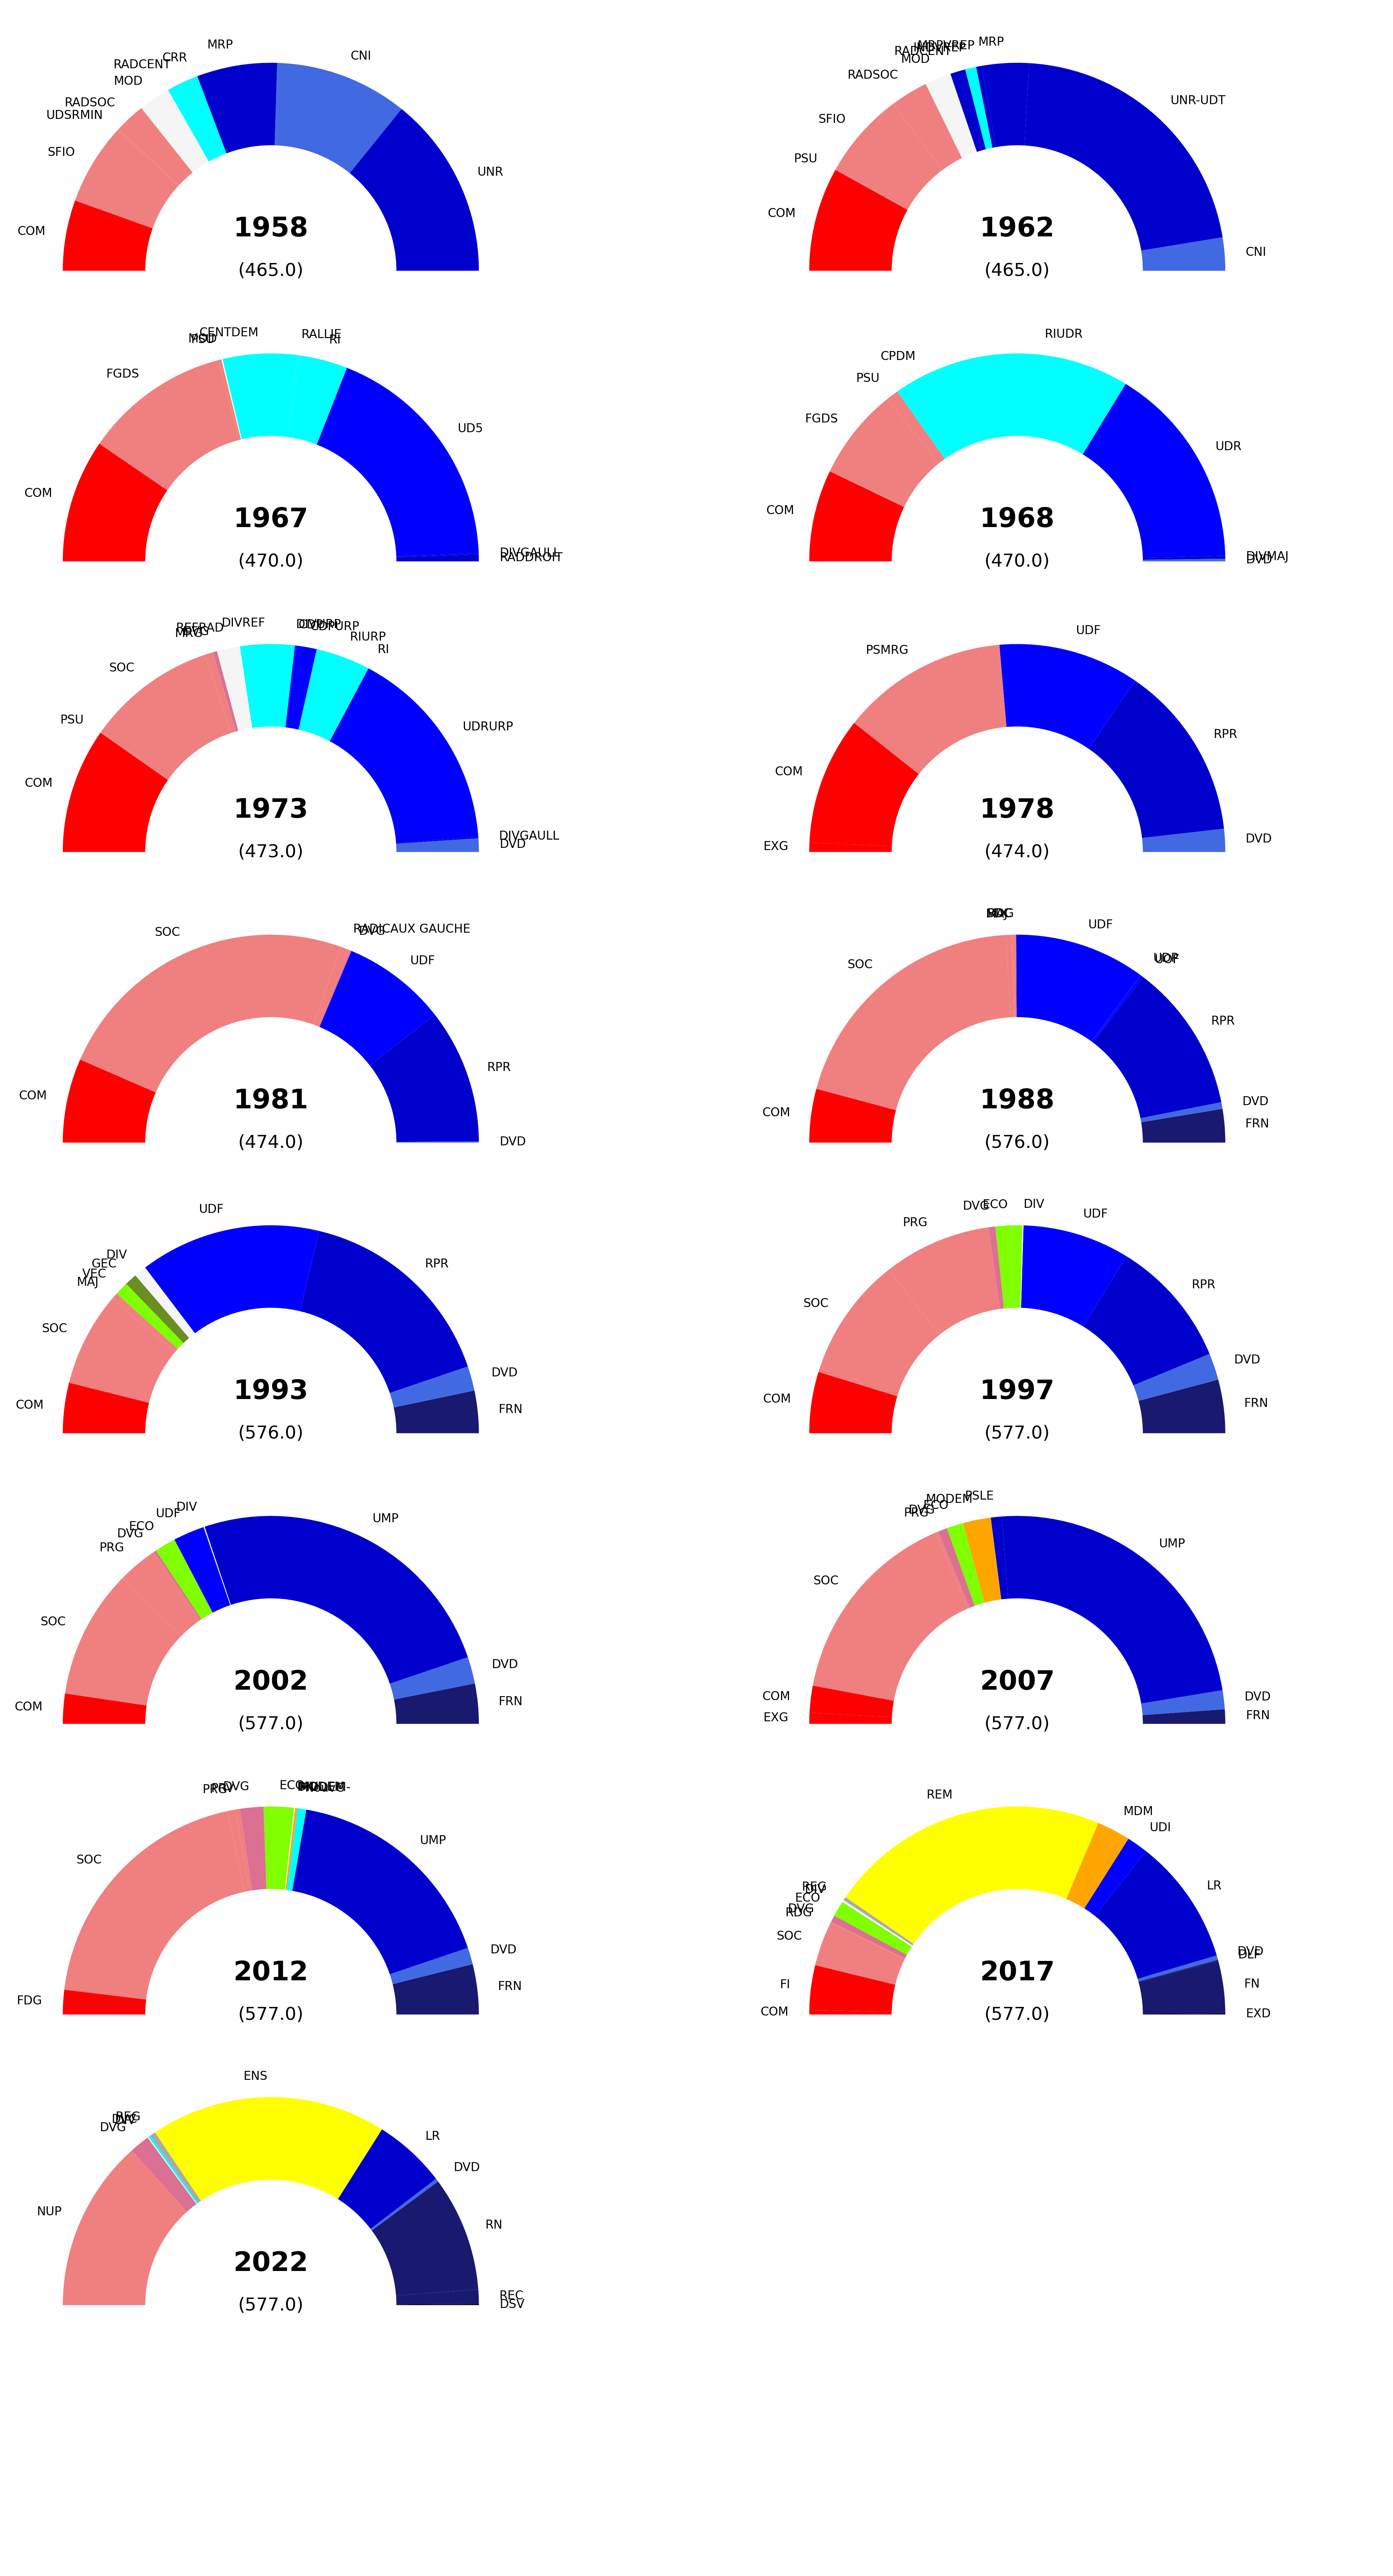

In [15]:
import matplotlib.pyplot as plt

def affiche_hemicycle(axe, annee, serie_label, serie_value, serie_color) :
    # Conversion
    labels = list(serie_label)
    values = list(serie_value)
    colors = list(serie_color)
    
    # nb sieges
    nb_sieges = sum(values)
    
    # Formation d'un hémicycle (50% du cercle non affiché)
    labels.append("")
    values.append(nb_sieges)
    colors.append('white')

    # Ajout du graphe dans le subplot
    axe.pie(values, labels=labels, colors=colors, textprops={'fontsize': 8})
    axe.add_artist(plt.Circle((0, 0), 0.6, color='white'))
    axe.text(0, 0.2, annee, horizontalalignment = 'center', verticalalignment = 'center',fontweight = 'bold', fontsize = 18) 
    axe.text(0, 0, '('+str(nb_sieges)+')', horizontalalignment = 'center', verticalalignment = 'center', fontsize = 12) 


    

# Affichage du résultat réel des éléction
fig, axes = plt.subplots(len(annees_election)//2+1,2, figsize=(35,24),dpi=300)

i = 0
for annee in annees_election :
    
    # Récup des données
    #dfm = vainqueurs_majoritaire_par_nuance(annee)
    dfp = proportionnelle_natio_plus_forte_moyenne(annee,3,50)
    #dfp = proportionnelle_departemental_plus_forte_moyenne(annee,3,50)
    dfp = dfp[dfp['Sièges']>0]
    
    affiche_hemicycle(
        axes[i//2,i%2], 
        annee,
        dfp['Nuance'],
        dfp['Sièges'],
        dfp['Couleur'])

    i += 1


axes[-1,-1].axis('off')
plt.gcf().subplots_adjust(hspace=-1,wspace=0)
plt.tight_layout(rect=[0, 0, 0.4, 1])

plt.show()


In [13]:

start = time.time()
for year in annees_election : 
    with pd.ExcelWriter("propnatio_"+str(year)+".xlsx") as writer :
        for taux in list(np.arange(0,100,5)) :
            for seuil in list(np.arange(0,20,1)) :
                #Moyenne des résultats
                temp = proportionnelle_natio_plus_forte_moyenne(year, seuil, taux)
                for k in range(N_iter-1):
                    temp["Sièges"] += proportionnelle_natio_plus_forte_moyenne(year, seuil, taux)["Sièges"]
                temp["Sièges"] = temp["Sièges"]/N_iter
                
                temp.to_excel(writer,sheet_name = "propnatio_"+str(year)+"_"+str(seuil)+"_"+str(taux))
    print(year)
duration = time.time()-start
print("Fichiers créés en une durée de : "+time.strftime("%H:%M:%S", time.gmtime(duration)))

1958
1962
1967
1968
1973
1978
1981
1988
1993
1997
2002
2007
2012
2017
2022
Fichiers créés en une durée de : 00:20:24


In [18]:
start = time.time()
for year in annees_election :
    if year >= 1981 :
        with pd.ExcelWriter("propregio_"+str(year)+".xlsx") as writer :
            for taux in list(np.arange(0,100,5)) :
                for seuil in list(np.arange(0,20,1)) :
                    #Moyenne des résultats
                    temp = proportionnelle_regional_plus_forte_moyenne(year, seuil, taux)
                    for k in range(N_iter-1):
                        temp["Sièges"] += proportionnelle_regional_plus_forte_moyenne(year, seuil, taux)["Sièges"]
                    temp["Sièges"] = temp["Sièges"]/N_iter

                    temp.to_excel(writer,sheet_name = "propregio_"+str(year)+"_"+str(seuil)+"_"+str(taux))
        print(year)
duration = time.time()-start
print("Fichiers créés en une durée de : "+time.strftime("%H:%M:%S", time.gmtime(duration)))

1981
1988
1993
1997
2002
2007
2012
2017
2022
Fichiers créés en une durée de : 01:04:54


In [20]:
start = time.time()
for year in annees_election : 
    with pd.ExcelWriter("propdep_"+str(year)+".xlsx") as writer :
        for taux in list(np.arange(0,100,5)) :
            for seuil in list(np.arange(0,20,1)) :
                #Moyenne des résultats
                temp = proportionnelle_departemental_plus_forte_moyenne(year, seuil, taux)
                for k in range(N_iter-1):
                    temp["Sièges"] += proportionnelle_departemental_plus_forte_moyenne(year, seuil, taux)["Sièges"]
                temp["Sièges"] = temp["Sièges"]/N_iter
                temp.to_excel(writer,sheet_name = "propdep_"+str(year)+"_"+str(seuil)+"_"+str(taux))
    print(year)

duration = time.time()-start
print("Fichiers créés en une durée de : "+time.strftime("%H:%M:%S", time.gmtime(duration)))

1958
1962
1967
1968
1973
1978
1981
1988
1993
1997
2002
2007
2012
2017
2022
Fichiers créés en une durée de : 07:11:33


In [32]:
start = time.time()
for year in annees_election : 
    with pd.ExcelWriter("majoritaire_"+str(year)+".xlsx") as writer :
        vainqueurs_majoritaire_par_nuance(year).to_excel(writer,sheet_name = "majoritaire_"+str(year))
        
duration = time.time()-start
print("Fichiers créés en une durée de : "+time.strftime("%H:%M:%S", time.gmtime(duration)))

IndexError: At least one sheet must be visible